In [1]:
import warnings
import gc
import os
import pickle
import gzip

import scanpy as sc
import numpy as np
import tensorflow as tf
import pandas as pd
import colorcet as cc
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors
import seaborn as sns
import altair as alt
import pertpy as pt

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

sccoda_model = pt.tl.Sccoda()

2025-01-20 12:43:17.068214: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 12:43:22.638207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-20 12:43:23.995788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-20 12:43:24.363506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-20 12:43:27.179527: I tensorflow/core/platform/cpu_feature_guar

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# plots settings
%matplotlib inline
palette = sns.color_palette(cc.glasbey_light, n_colors=35)
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(palette.as_hex())

# function that changes width of bars in barpltos
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# display all columns
pd.set_option('display.max_columns', None)

In [3]:
bro_path = "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_annotated_mossi_integrated.h5ad"
hnoca_path = "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/HNOCA/hnoca_pre-release_public_subset.h5ad"
combined_path= "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_joint_hnoca.h5ad"

output = "/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/04_Abundance_analysis/"

In [ ]:
bro = sc.read_h5ad(bro_path)

In [ ]:
hnoca = sc.read_h5ad(hnoca_path)

In [ ]:
bro.obs['publication'] = "Bessler et al., this study"
bro.obs['annot_level_1'] = bro.obs['hnoca_level_1']
bro.obs['annot_level_2'] = bro.obs['hnoca_level_2']
bro.obs['annot_level_3'] = bro.obs['hnoca_level_3']

In [ ]:
del bro.obsp
del bro.layers

In [ ]:
del hnoca.layers
del hnoca.obsp

In [ ]:
hnoca.obs['Day'] = hnoca.obs['organoid_age_days'].astype(int)

In [ ]:
bro.obs['Day'] = bro.obs['Day'].astype(int)

In [ ]:
adata = sc.concat(
    [hnoca, bro],
    axis=0,
    join="outer",
)

In [ ]:
for o in adata.obs:
    adata.obs[o] = adata.obs[o].astype('str')

In [5]:
adata.write_h5ad("/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/data/BRO_timecourse/BRO_RA1_exp023_joint_hnoca.h5ad")

In [6]:
adata = sc.read_h5ad(combined_path)

In [ ]:
adata.obs['publication_covariate'] = adata.obs['publication']
adata.obs['publication_covariate'] = adata.obs['publication_covariate'].apply(lambda x: 'HNOCA, 2024' if x != 'Bessler et al., this study' else x)

In [ ]:
adata.obs['bio_sample'] = adata.obs['bio_sample'].astype(str)
adata.obs['Day'] = adata.obs['Day'].astype(str)

In [ ]:
adata.obs.loc[adata.obs['publication_covariate'] == 'Bessler et al., this study', 'bio_sample'] = 'Bessler_day' + adata.obs['Day']

In [8]:
# remove PSC and neuroepithelium - displays only the early stages
adata = adata[adata.obs['annot_level_3'] != 'PSC']
adata = adata[adata.obs['annot_level_3'] != 'Neuroepithelium']

# remove differentiation side effects and mesodermal lineages - not looking into those
adata = adata[adata.obs['annot_level_3'] != 'MC']
adata = adata[adata.obs['annot_level_3'] != 'NC Derivatives']
adata = adata[adata.obs['annot_level_3'] != 'CP']
adata = adata[adata.obs['annot_level_3'] != 'EC']
adata = adata[adata.obs['annot_level_3'] != 'Microglia']

# remove incomplete regionality annotation of NPC (for now)
adata = adata[adata.obs['annot_level_3'] != 'NPC']

In [9]:
# for fair comparisons we also remove all hnoca timepoints after our max timepoint (d120) and subset on >d30
adata.obs['Day_numeric'] = adata.obs['Day'].astype(int)
adata = adata[adata.obs['Day_numeric'] <= 120]
adata = adata[adata.obs['Day_numeric'] >= 30]

In [10]:
#reorder publications for proper plotting and modelling
adata.obs['publication_covariate'] = adata.obs['publication_covariate'].astype("category").cat.reorder_categories(['HNOCA, 2024','Bessler et al., this study'])

In [11]:
for ct in adata.obs['annot_level_3'].unique():
    print(f'"{ct}":"",')

"Medulla NPC":"",
"Medulla Neuron":"",
"Pons NPC":"",
"Ventral Midbrain Neuron":"",
"Pons Neuron":"",
"Cerebellar NPC":"",
"Dorsal Midbrain NPC":"",
"Thalamic NPC":"",
"Hypothalamic Neuron":"",
"Ventral Telencephalic Neuron":"",
"Hypothalamic NPC":"",
"Thalamic Neuron":"",
"Cerebellar Neuron":"",
"Ventral Telencephalic NPC":"",
"Dorsal Telencephalic NPC":"",
"Dorsal Telencephalic Neuron":"",
"Dorsal Midbrain Neuron":"",
"Ventral Midbrain NPC":"",
"Glioblast":"",
"OPC":"",
"Dorsal Telencephalic IP":"",
"Astrocyte":"",


In [19]:
region_ct = {
    "Medulla NPC":"Medulla",
    "Medulla Neuron":"Medulla",
    "Pons NPC":"Pons",
    "Ventral Midbrain Neuron":"Midbrain",
    "Pons Neuron":"Pons",
    "Cerebellar NPC":"Cerebellum",
    "Dorsal Midbrain NPC":"Midbrain",
    "Thalamic NPC":"Thalamus",
    "Hypothalamic Neuron":"Hypothalamus",
    "Ventral Telencephalic Neuron":"Telencephalon",
    "Hypothalamic NPC":"Hypothalamus",
    "Thalamic Neuron":"Thalamus",
    "Cerebellar Neuron":"Cerebellum",
    "Ventral Telencephalic NPC":"Telencephalon",
    "Dorsal Telencephalic NPC":"Telencephalon",
    "Dorsal Telencephalic Neuron":"Telencephalon",
    "Dorsal Midbrain Neuron":"Midbrain",
    "Ventral Midbrain NPC":"Midbrain",
    "Glioblast":"Glioblast",
    "OPC":"OPC",
    "Dorsal Telencephalic IP":"Telencephalon",
    "Astrocyte":"Astrocyte",
}

In [20]:
adata.obs['annot_level_3_region'] = adata.obs['annot_level_3'].map(region_ct)
adata.obs['annot_level_3_region'].value_counts()

annot_level_3_region
Telencephalon    727879
Medulla           97950
Cerebellum        59652
Thalamus          52023
Pons              49200
Hypothalamus      45389
Glioblast         44359
Midbrain          27357
Astrocyte          6369
OPC                4373
Name: count, dtype: int64

In [21]:
adata.obs['hnoca_leiden_level_3'].value_counts()

hnoca_leiden_level_3
nan                     1099778
Medulla NPC                4192
Medulla Neuron             2600
Pons NPC                   1734
Glioblast                  1587
Dorsal Midbrain NPC         917
Ventral Midbrain NPC        835
MC                          778
OPC                         552
Hypothalamic NPC            366
Cerebellar NPC              343
Neuroepithelium             324
NPC                         256
Astrocyte                   190
Hypothalamic Neuron          95
NC Derivatives                4
Name: count, dtype: int64

In [22]:
adata.obs['hnoca_level_3'].value_counts()

hnoca_level_3
nan                            1099778
Medulla NPC                       3419
Pons NPC                          2337
Glioblast                         1881
Medulla Neuron                    1554
Dorsal Midbrain NPC               1078
Cerebellar NPC                     950
Ventral Midbrain NPC               947
Hypothalamic NPC                   571
Pons Neuron                        419
OPC                                382
Astrocyte                          360
Cerebellar Neuron                  238
Hypothalamic Neuron                203
Thalamic NPC                       169
Thalamic Neuron                    155
Dorsal Midbrain Neuron              64
Ventral Midbrain Neuron             24
Dorsal Telencephalic Neuron         20
Dorsal Telencephalic NPC             2
Name: count, dtype: int64

### Abundance per timepoint

In [27]:
## organize the timepoints into bins
bins = [0, 60, 120]
labels = ['mid','late']

adata.obs["binned_ages"] = pd.cut(
    adata.obs["Day_numeric"], bins=bins, labels=labels
).astype('str')
print(adata.obs["binned_ages"].value_counts())

binned_ages
mid     565060
late    549491
Name: count, dtype: int64


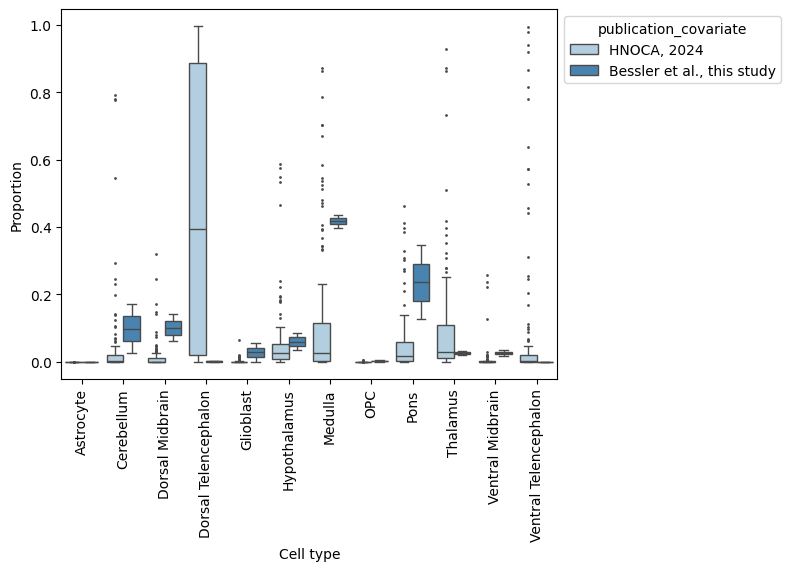

In [22]:
sccoda_model.plot_boxplots(sccoda_data_tmp, feature_name="publication_covariate")
plt.show()

late
Day
120    3221
90     1664
Name: count, dtype: int64


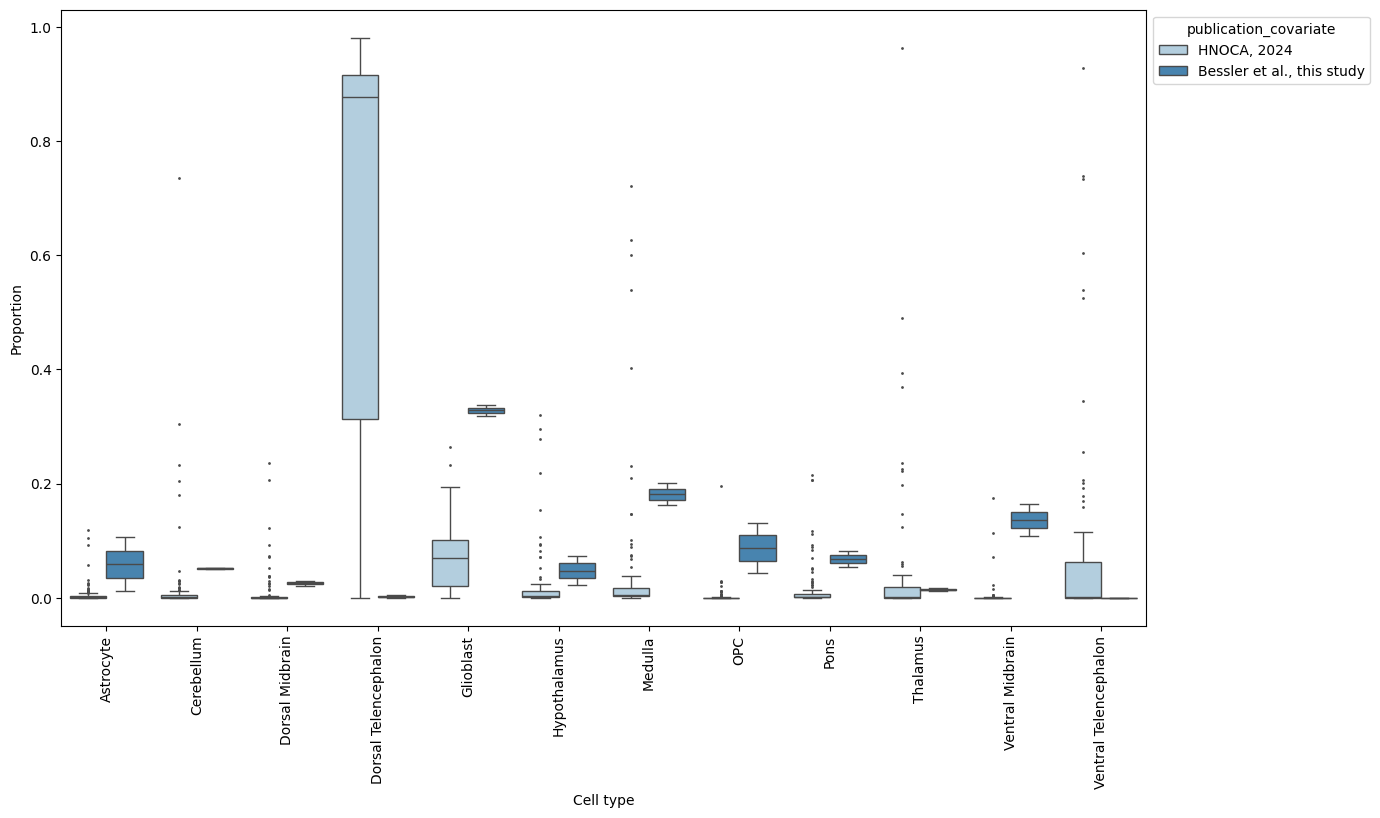

Reference: Medulla
• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [06:44<00:00, 27.19it/s, 127 steps of size 4.01e-02. acc. prob=0.75]


Reference: Pons


sample: 100%|██████████| 11000/11000 [08:12<00:00, 22.32it/s, 127 steps of size 3.59e-02. acc. prob=0.76]


Reference: Ventral Midbrain


sample: 100%|██████████| 11000/11000 [07:42<00:00, 23.77it/s, 127 steps of size 4.01e-02. acc. prob=0.75]


Reference: Cerebellum


sample: 100%|██████████| 11000/11000 [08:47<00:00, 20.87it/s, 127 steps of size 2.88e-02. acc. prob=0.85]


Reference: Dorsal Midbrain


sample: 100%|██████████| 11000/11000 [08:04<00:00, 22.72it/s, 127 steps of size 3.72e-02. acc. prob=0.72]


Reference: Thalamus


sample: 100%|██████████| 11000/11000 [08:40<00:00, 21.14it/s, 127 steps of size 2.62e-02. acc. prob=0.85]


Reference: Hypothalamus


sample: 100%|██████████| 11000/11000 [05:57<00:00, 30.73it/s, 63 steps of size 4.63e-02. acc. prob=0.64] 


Reference: Ventral Telencephalon


sample: 100%|██████████| 11000/11000 [08:46<00:00, 20.88it/s, 127 steps of size 2.72e-02. acc. prob=0.81]


Reference: Dorsal Telencephalon


sample: 100%|██████████| 11000/11000 [16:42<00:00, 10.97it/s, 255 steps of size 1.63e-02. acc. prob=0.85]


Reference: Glioblast


sample: 100%|██████████| 11000/11000 [08:19<00:00, 22.02it/s, 127 steps of size 3.58e-02. acc. prob=0.81]


Reference: OPC


sample: 100%|██████████| 11000/11000 [08:12<00:00, 22.34it/s, 127 steps of size 3.69e-02. acc. prob=0.76]


Reference: Astrocyte


sample: 100%|██████████| 11000/11000 [08:24<00:00, 21.79it/s, 127 steps of size 3.35e-02. acc. prob=0.77]


mid
Day
30    5227
60    4661
Name: count, dtype: int64


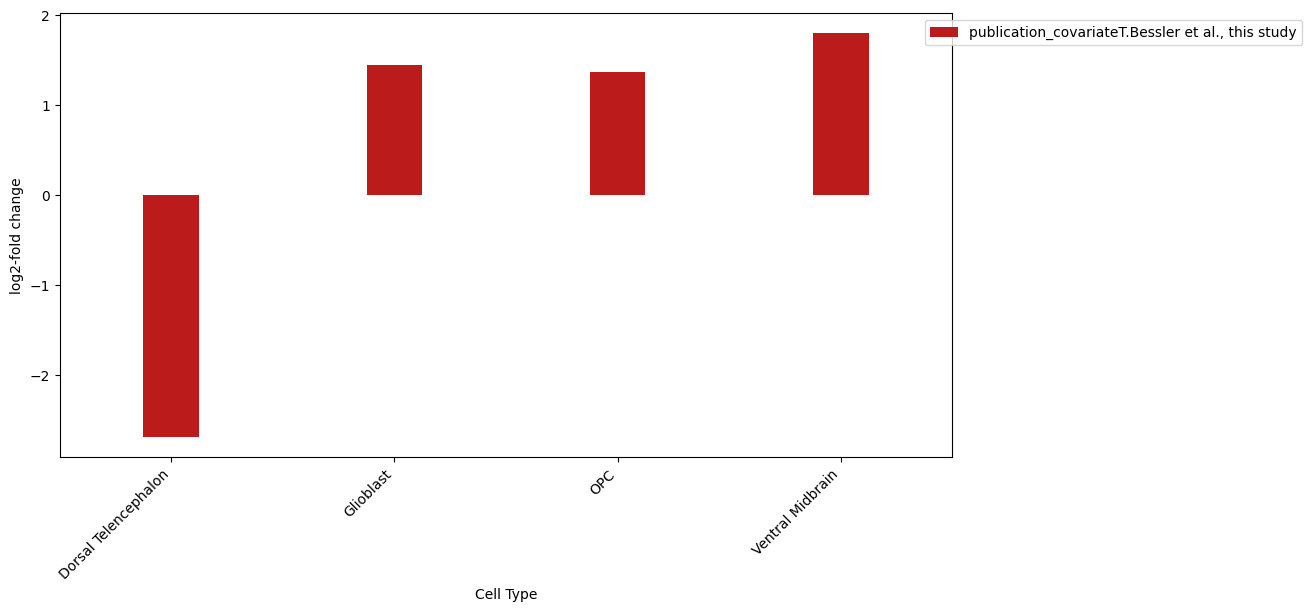

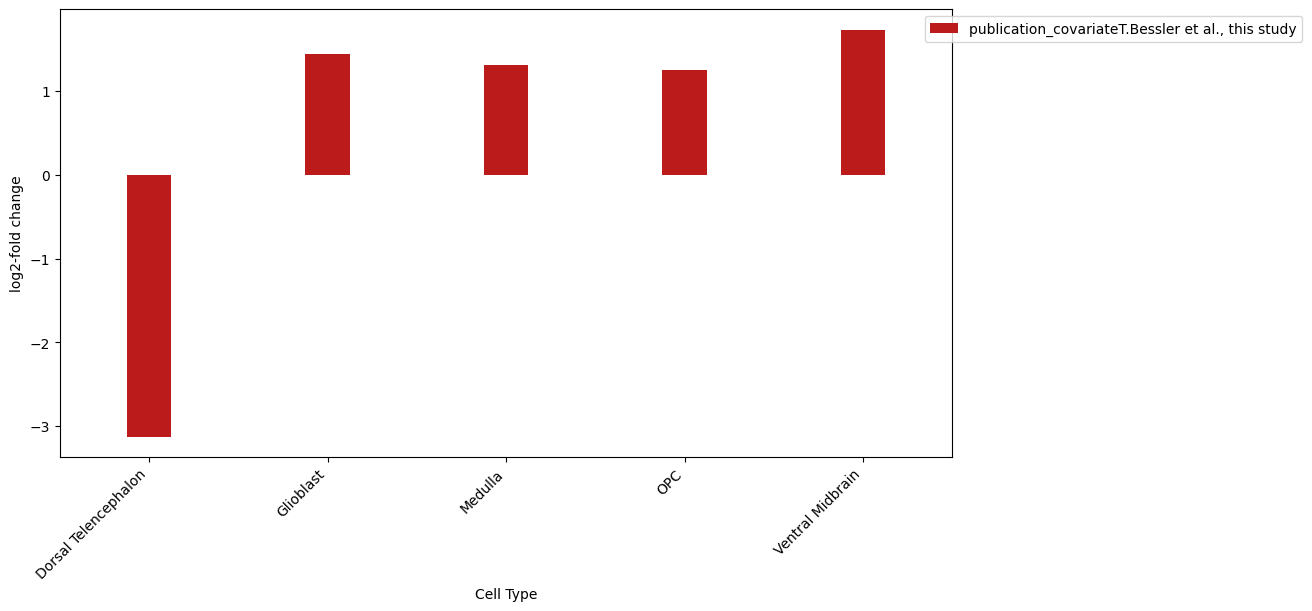

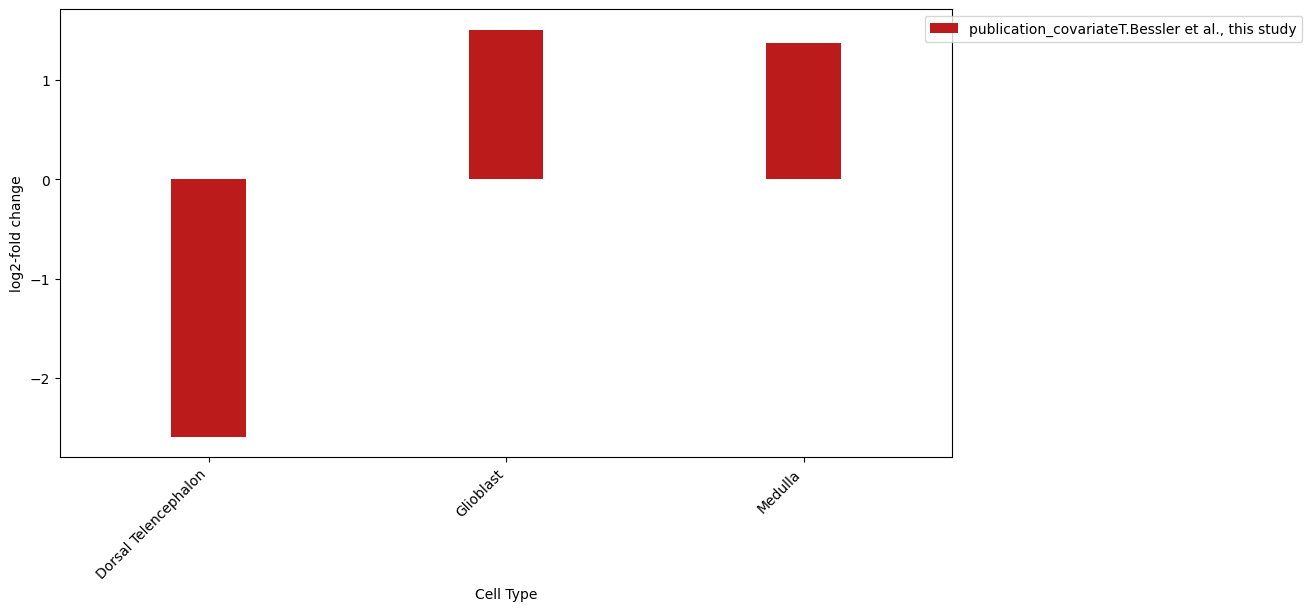

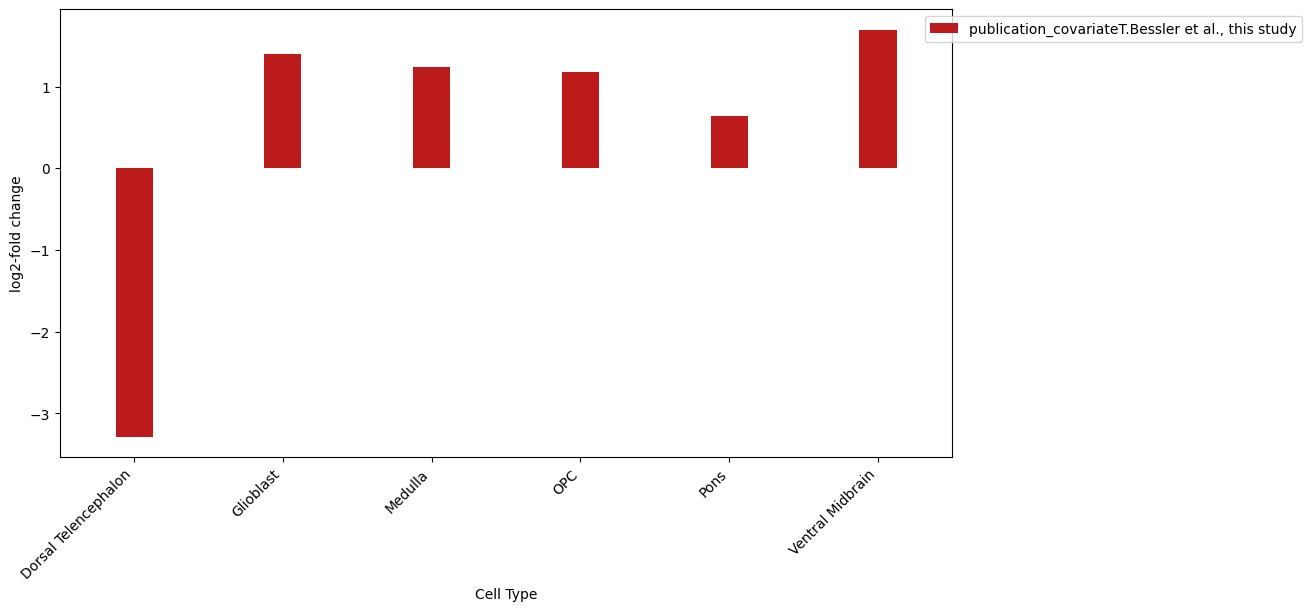

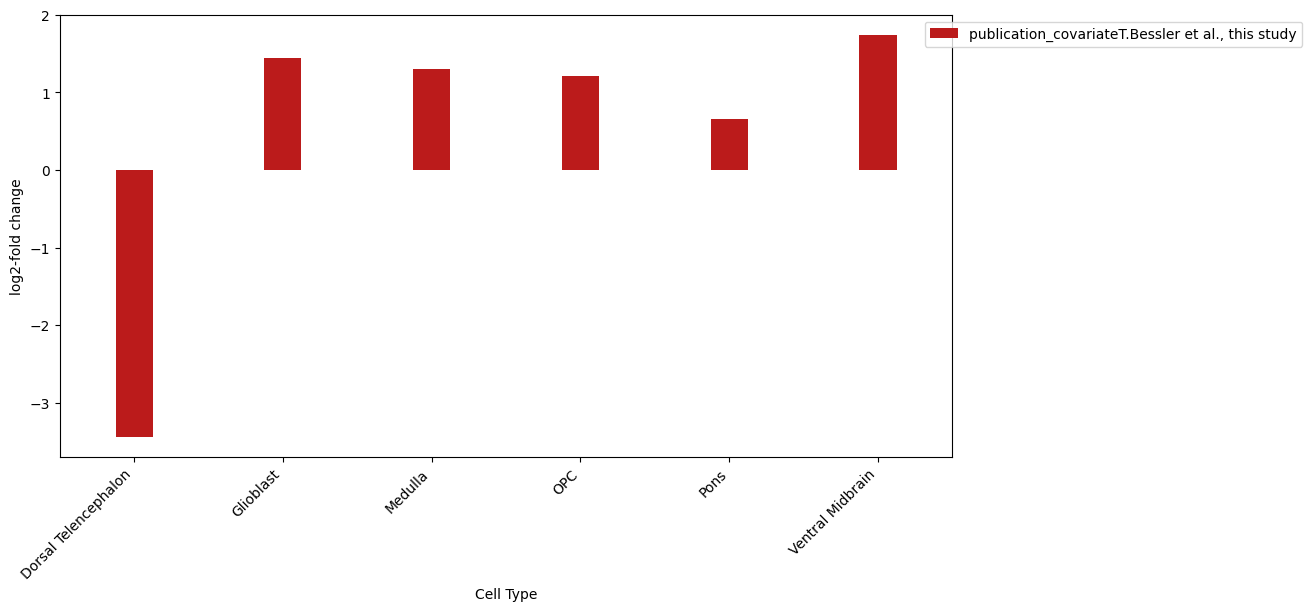

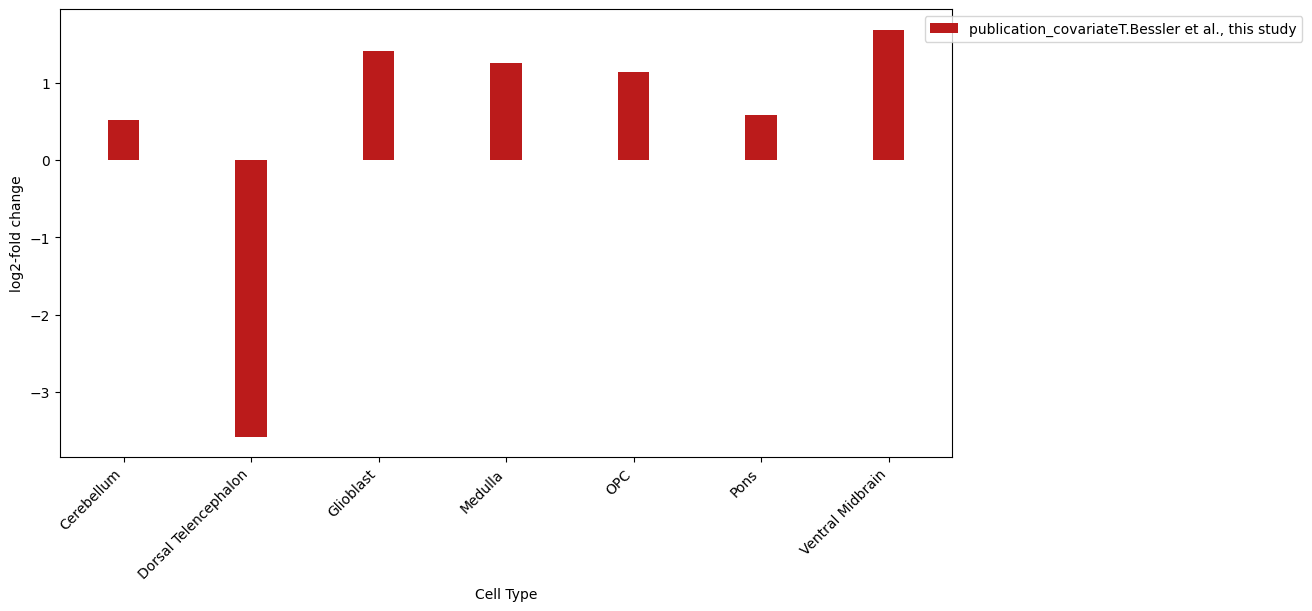

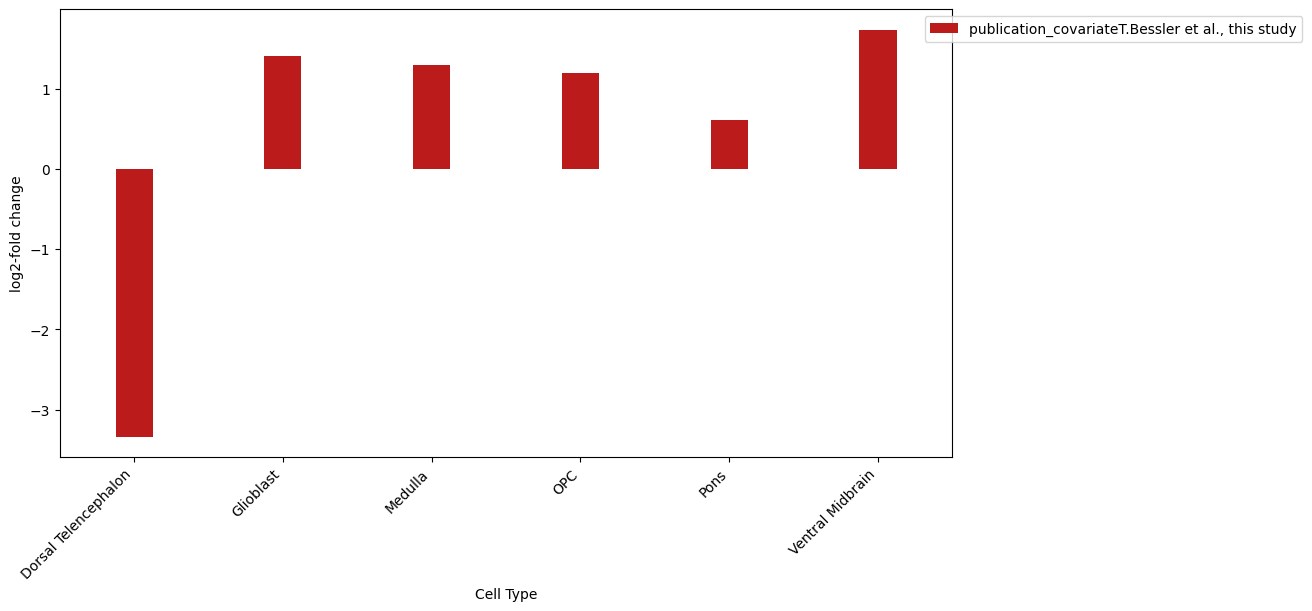

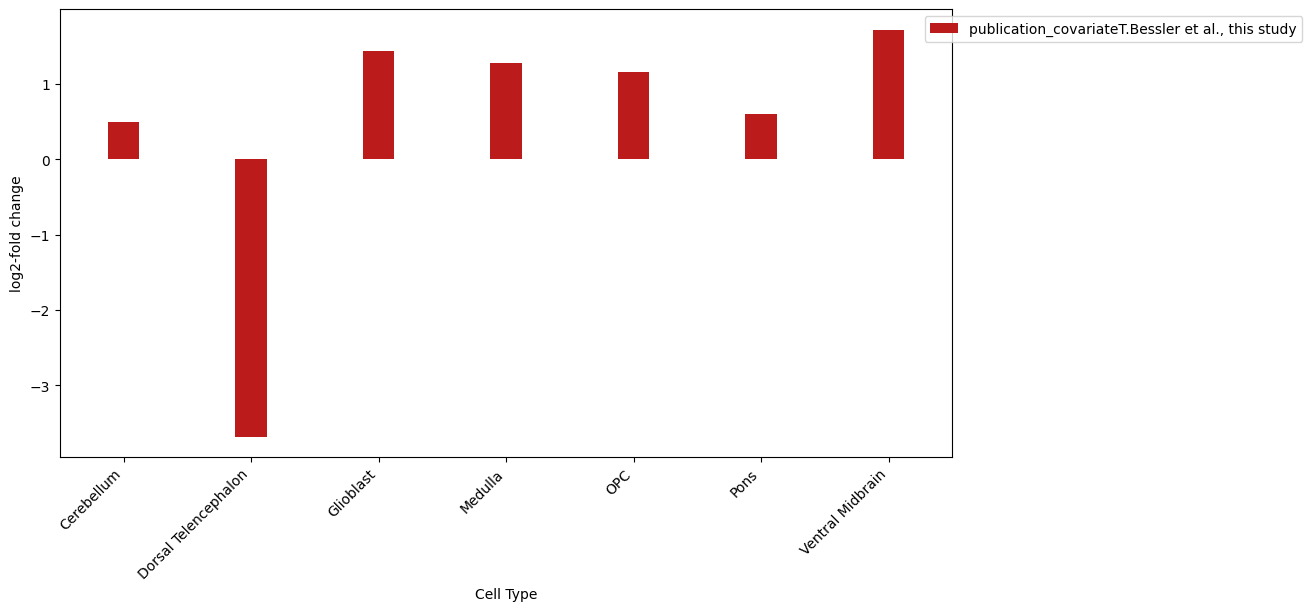

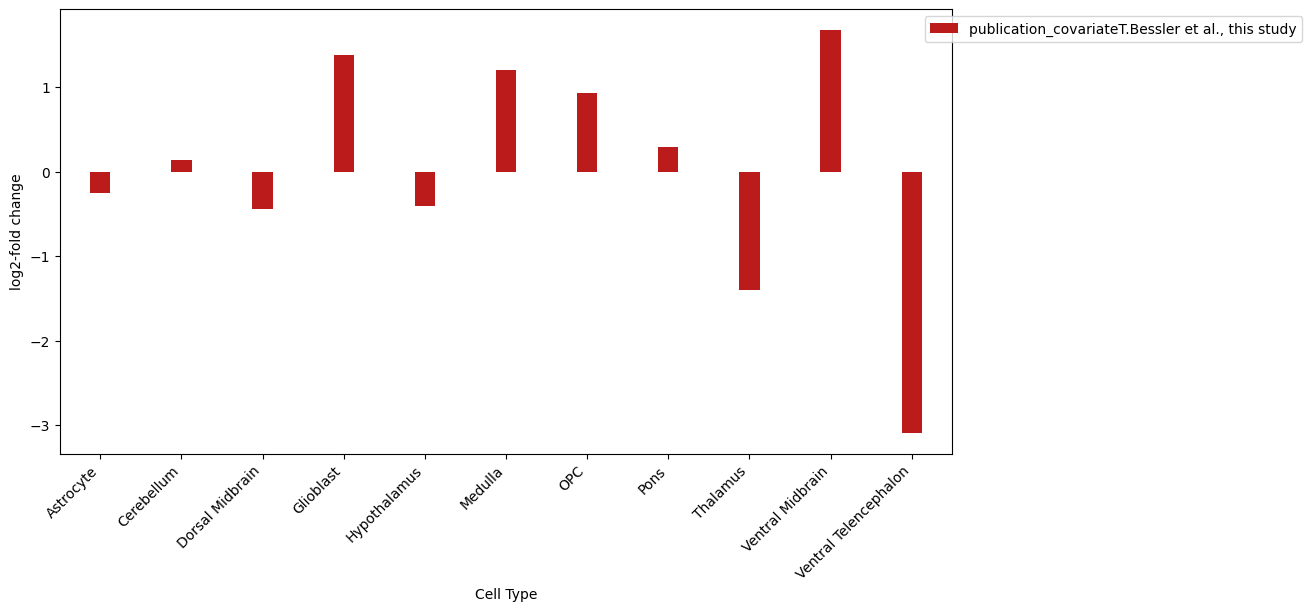

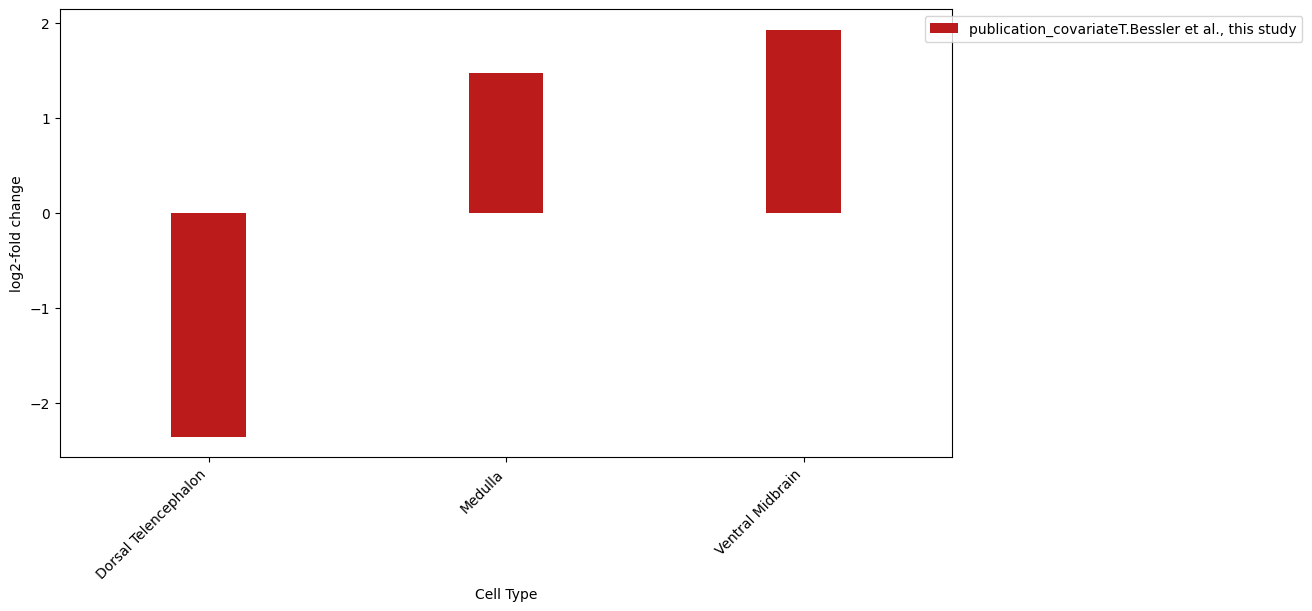

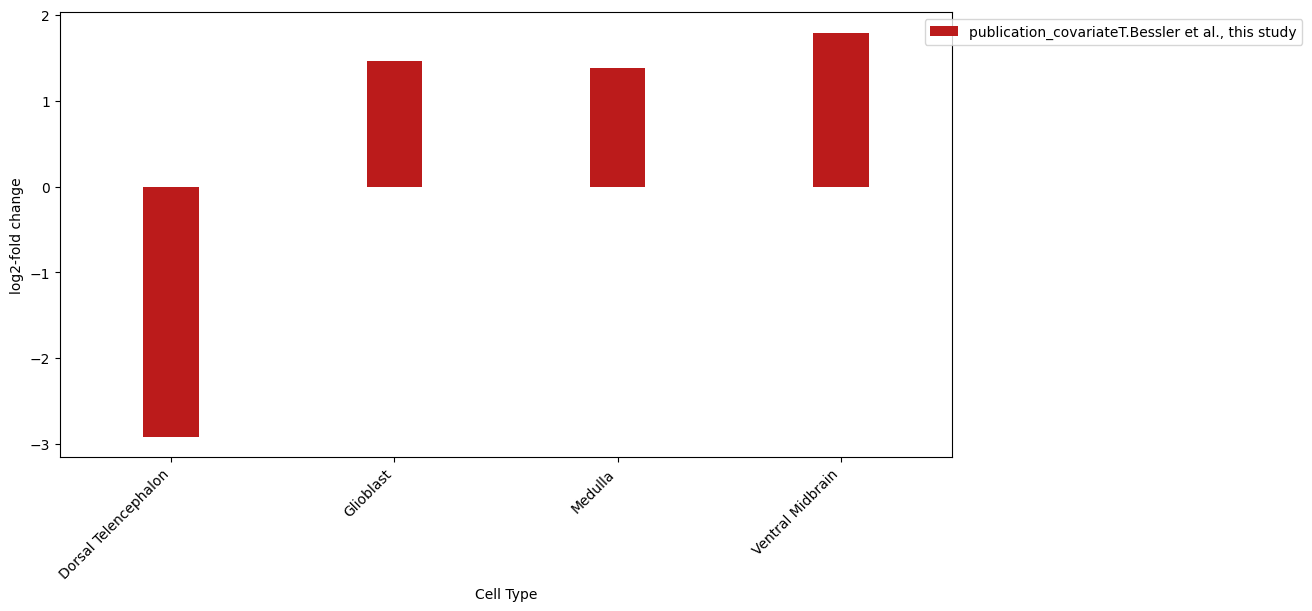

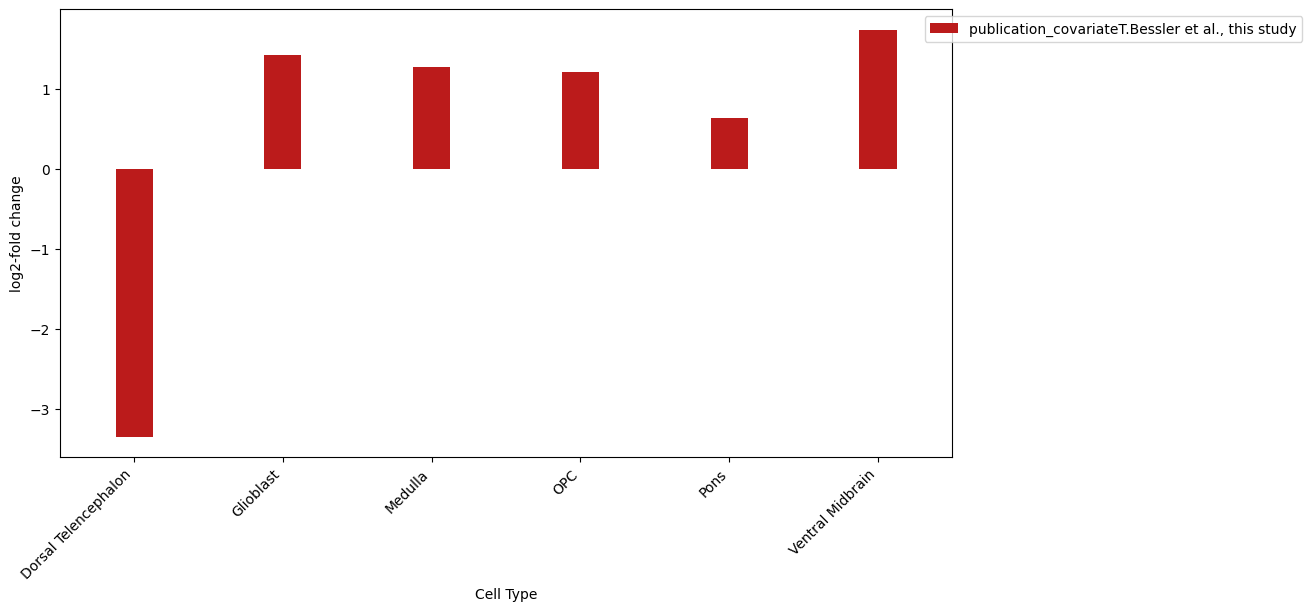

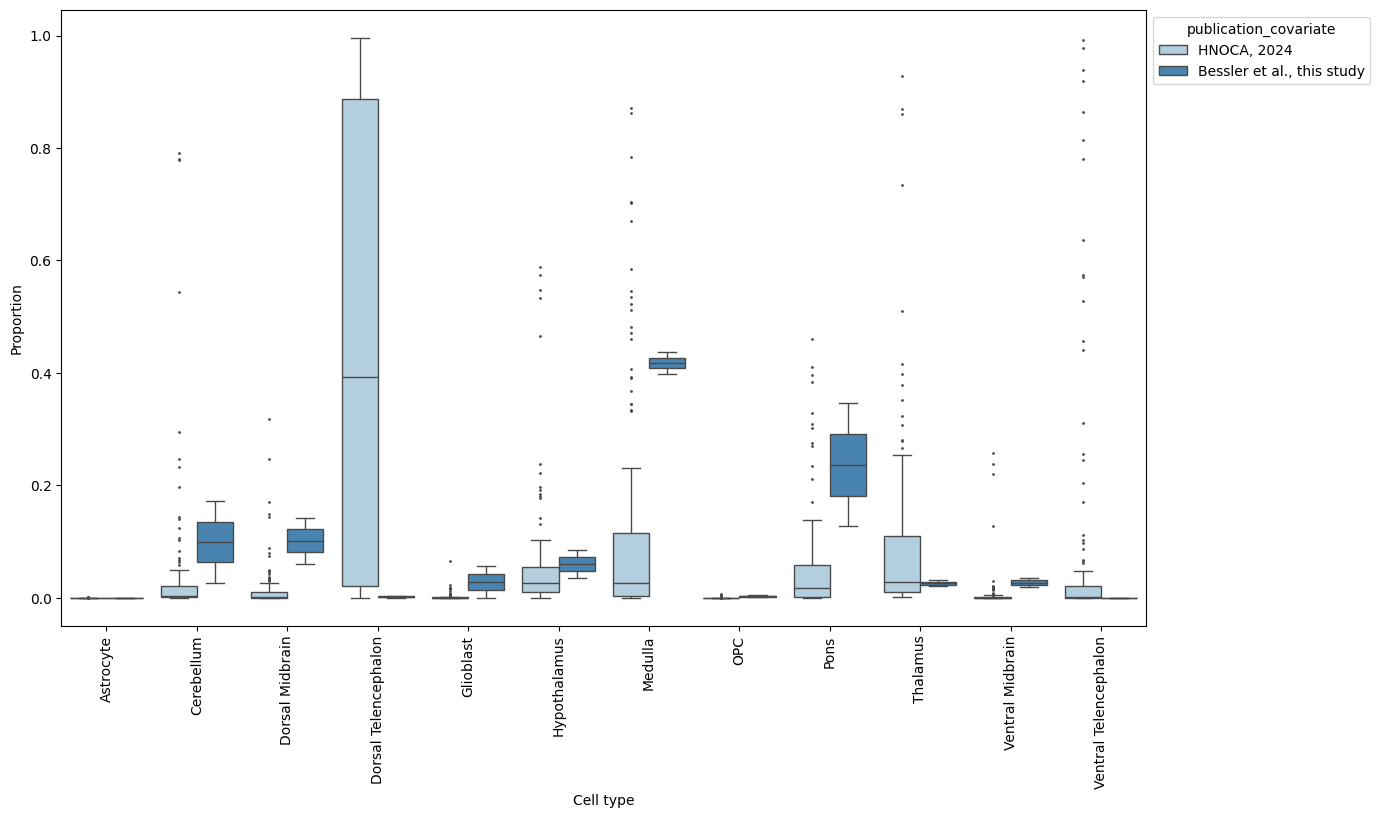

Reference: Medulla
• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████| 11000/11000 [04:14<00:00, 43.26it/s, 63 steps of size 7.99e-02. acc. prob=0.68]


Reference: Pons


sample: 100%|██████████| 11000/11000 [04:32<00:00, 40.41it/s, 63 steps of size 6.19e-02. acc. prob=0.74]


Reference: Ventral Midbrain


sample: 100%|██████████| 11000/11000 [04:34<00:00, 40.03it/s, 63 steps of size 7.55e-02. acc. prob=0.53]


! Acceptance rate unusually low (0.5321423061891456 < 0.5)! Results might be incorrect! Please check feasibility of results and re-run the sampling step with a different rng_key if necessary.
Reference: Cerebellum


sample: 100%|██████████| 11000/11000 [05:18<00:00, 34.58it/s, 63 steps of size 4.92e-02. acc. prob=0.74] 


Reference: Dorsal Midbrain


sample: 100%|██████████| 11000/11000 [06:47<00:00, 27.02it/s, 127 steps of size 4.49e-02. acc. prob=0.79]


Reference: Thalamus


sample: 100%|██████████| 11000/11000 [07:41<00:00, 23.83it/s, 127 steps of size 4.12e-02. acc. prob=0.74]


Reference: Hypothalamus


sample:  36%|███▌      | 3978/11000 [02:25<03:02, 38.42it/s, 63 steps of size 4.62e-02. acc. prob=0.74] 

In [81]:
cell_types = adata.obs['annot_level_3_region'].unique()
results_cycle = pd.DataFrame(index=cell_types, columns=adata.obs["binned_ages"].unique()).fillna(0)

for time in np.sort(adata.obs['binned_ages'].unique()):
    print(time)

    adata_tmp = adata[adata.obs['binned_ages']==time]
    print(adata_tmp[adata_tmp.obs['publication_covariate']=='Bessler et al., this study'].obs['Day'].value_counts())
    
    sccoda_data_tmp = sccoda_model.load(
        adata_tmp,
        type="cell_level",
        generate_sample_level=True,
        cell_type_identifier="annot_level_3_region",
        sample_identifier="bio_sample",
        covariate_obs=["publication_covariate"],
    )

    sccoda_model.plot_boxplots(sccoda_data_tmp, feature_name="publication_covariate", figsize=[14,8])
    plt.savefig(fname=output+'scCODA_'+time+'_prop_boxplot.pdf',format='pdf')
    plt.show()  

    for ct in cell_types:
        print(f"Reference: {ct}")

        # Run inference
        sccoda_data_all = sccoda_model.prepare(sccoda_data_tmp, 
                                            modality_key="coda", 
                                            formula="publication_covariate", 
                                            reference_cell_type=ct)
        sccoda_model.run_nuts(sccoda_data_all, modality_key="coda")
        sccoda_model.set_fdr(sccoda_data_all, 0.2)
        
        cred_eff = sccoda_model.credible_effects(sccoda_data_all, modality_key="coda")
        
        # add up credible effects
        cred_eff.index = cred_eff.index.get_level_values(1)
        results_cycle[time] += cred_eff.astype("int")
        
        df_cred = sccoda_model.get_effect_df(sccoda_data_all, modality_key="coda")
        df_cred.reset_index(inplace=True)
        df_cred = df_cred[df_cred["Final Parameter"]!=0.0]

        # save the credible effects
        df_cred.to_csv(os.path.join(output, time + ct+'_scCODA_credible_change_bio_sample_final_region.csv')) 

        fig, ax = plt.subplots(figsize=(13, 6), constrained_layout=True)
        sns.barplot(data=df_cred, 
                    x="Cell Type", 
                    y="log2-fold change", 
                    hue="Covariate",
                palette = palette)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.legend(loc='upper right', bbox_to_anchor=(1.4,1), ncol=1)
        change_width(ax, .25)
        plt.savefig(fname=output+'scCODA_credible_effect_ref_'+time+ct+'_LFC.pdf',format='pdf')
        labels = ax.get_xticklabels()

In [ ]:
print(results_cycle)

                       mid  late
Medulla                  9    11
Pons                     7     2
Ventral Midbrain         0    11
Cerebellum               0     1
Dorsal Midbrain          1     0
Thalamus                 0     0
Hypothalamus             0     0
Ventral Telencephalon    0     0
Dorsal Telencephalon     8    11
Glioblast                0     1
OPC                      0    10
Astrocyte                0     0


### Output

In [16]:
cell_types = adata.obs['annot_level_3_region'].unique()
cred_list = {'mid':{},'late':{}}
results_cycle_2 = pd.DataFrame()
res_LFC=pd.DataFrame()

In [17]:
cell_types

array(['Medulla', 'Pons', 'Ventral Midbrain', 'Cerebellum',
       'Dorsal Midbrain', 'Thalamus', 'Hypothalamus',
       'Ventral Telencephalon', 'Dorsal Telencephalon', 'Glioblast',
       'OPC', 'Astrocyte'], dtype=object)

In [20]:
for time in np.sort(adata.obs['binned_ages'].unique()):
    print(time)

    for ct in adata.obs['annot_level_3_region'].unique():
        print(ct)
        df_cred=pd.read_csv(os.path.join(output, time+ct+'_scCODA_credible_change_bio_sample_final_region.csv'))
        df_cred = df_cred.rename(columns={"Cell Type": 'Region'})
        df_cred['Publication'] = df_cred['Covariate'].str.split(".").str[1]
        df_cred["Publication"] = df_cred["Publication"].astype('category')
        df_cred["Age_Region"]= time +'_'+df_cred['Region'].astype('str')
        df_cred['Reference:'+ct]=1
        
        results=df_cred[['Age_Region','Reference:'+ct]]
        results.index = results['Age_Region']
        del results['Age_Region']
        results_cycle_2 = results_cycle_2.add(results, fill_value=0)
        
        df_cred['Reference:'+ct+'_LFC']=df_cred['log2-fold change']
        res=df_cred[['Age_Region','Reference:'+ct+'_LFC']]
        res.index = res['Age_Region']
        del res['Age_Region']
        res_LFC = res_LFC.add(res, fill_value=0)
        
        cred_list[time].update({ct:df_cred})

late
Medulla
Pons
Ventral Midbrain
Cerebellum
Dorsal Midbrain
Thalamus
Hypothalamus
Ventral Telencephalon
Dorsal Telencephalon
Glioblast
OPC
Astrocyte
mid
Medulla
Pons
Ventral Midbrain
Cerebellum
Dorsal Midbrain
Thalamus
Hypothalamus
Ventral Telencephalon
Dorsal Telencephalon
Glioblast
OPC
Astrocyte


In [21]:
results_cycle_2.fillna(0, inplace=True)
results_cycle_2

,Reference:Astrocyte,Reference:Cerebellum,Reference:Dorsal Midbrain,Reference:Dorsal Telencephalon,Reference:Glioblast,Reference:Hypothalamus,Reference:Medulla,Reference:OPC,Reference:Pons,Reference:Thalamus,Reference:Ventral Midbrain,Reference:Ventral Telencephalon
Age_Region,,,,,,,,,,,,
late_Astrocyte,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
late_Cerebellum,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
late_Dorsal Midbrain,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
late_Dorsal Telencephalon,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
late_Glioblast,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
late_Hypothalamus,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
late_Medulla,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
late_OPC,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
late_Pons,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [22]:
res_LFC.fillna(0, inplace=True)
res_LFC

,Reference:Astrocyte_LFC,Reference:Cerebellum_LFC,Reference:Dorsal Midbrain_LFC,Reference:Dorsal Telencephalon_LFC,Reference:Glioblast_LFC,Reference:Hypothalamus_LFC,Reference:Medulla_LFC,Reference:OPC_LFC,Reference:Pons_LFC,Reference:Thalamus_LFC,Reference:Ventral Midbrain_LFC,Reference:Ventral Telencephalon_LFC
Age_Region,,,,,,,,,,,,
late_Astrocyte,0.000000,0.000000,0.000000,-0.256601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
late_Cerebellum,0.000000,0.000000,0.000000,0.135968,0.000000,0.000000,0.000000,0.000000,0.000000,0.520260,0.000000,0.502113
late_Dorsal Midbrain,0.000000,0.000000,0.000000,-0.437560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
late_Dorsal Telencephalon,-3.348766,-3.283720,-3.439149,0.000000,-2.353468,-3.336755,-2.682509,-2.914433,-3.124122,-3.581913,-2.591499,-3.679059
late_Glioblast,1.416110,1.404763,1.447844,1.379055,0.000000,1.410489,1.446636,1.467666,1.448638,1.414090,1.508412,1.439160
late_Hypothalamus,0.000000,0.000000,0.000000,-0.411115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
late_Medulla,1.274907,1.239812,1.298605,1.202667,1.471454,1.298093,0.000000,1.377250,1.307115,1.261856,1.375778,1.282464
late_OPC,1.206757,1.183540,1.207501,0.933487,0.000000,1.192933,1.369712,0.000000,1.251902,1.146543,0.000000,1.159507
late_Pons,0.629510,0.646170,0.658917,0.285188,0.000000,0.614110,0.000000,0.000000,0.000000,0.590021,0.000000,0.598095


In [23]:
results_sum = pd.DataFrame(results_cycle_2.sum(axis=1))
results_sum = results_sum.rename(columns={0: 'times_credible'})
results_sum["pct_credible"] = results_sum["times_credible"]/len(cell_types)
results_sum["is_credible"] = results_sum["pct_credible"] > 0.5
results_sum

,times_credible,pct_credible,is_credible
Age_Region,,,
late_Astrocyte,1.0,0.083333,False
late_Cerebellum,3.0,0.250000,False
late_Dorsal Midbrain,1.0,0.083333,False
late_Dorsal Telencephalon,11.0,0.916667,True
late_Glioblast,11.0,0.916667,True
late_Hypothalamus,1.0,0.083333,False
late_Medulla,11.0,0.916667,True
late_OPC,9.0,0.750000,True
late_Pons,7.0,0.583333,True


In [24]:
res_credible = results_sum[results_sum['is_credible']==True]
res_credible.shape

(8, 3)

In [25]:
assert np.all(res_LFC.index == results_sum.index)
res_LFC
res_LFC_T = res_LFC[results_sum["is_credible"]==True]

df = pd.DataFrame(res_LFC.mean(axis=1))
df.loc[results_sum["is_credible"]==False, 0] = 0
df

,0
Age_Region,
late_Astrocyte,0.000000
late_Cerebellum,0.000000
late_Dorsal Midbrain,0.000000
late_Dorsal Telencephalon,-2.861283
late_Glioblast,1.315239
late_Hypothalamus,0.000000
late_Medulla,1.199167
late_OPC,0.887657
late_Pons,0.335168


In [26]:
# make a multiindex 
arrays = [[item[0] for item in res_LFC.index.str.split('_')],
         ["_".join(item[1:]) for item in res_LFC.index.str.split('_')]]
index = pd.MultiIndex.from_arrays(arrays, names=('Age', 'Region'))
df.index = index

In [74]:
df_res = df.unstack(level=1)
df_res.columns = df_res.columns.droplevel()
df_res = df_res.T.fillna(0)
df_res

Age,late,mid
Region,,
Astrocyte,0.000000,0.000000
Cerebellum,0.000000,0.000000
Dorsal Midbrain,0.000000,0.000000
Dorsal Telencephalon,-2.861283,-1.363339
Glioblast,1.315239,0.000000
Hypothalamus,0.000000,0.000000
Medulla,1.199167,1.366194
OPC,0.887657,0.000000
Pons,0.335168,0.000000


In [28]:
df_freq = pd.DataFrame(results_cycle_2.sum(axis=1))
arrays = [[item[0] for item in df_freq.index.str.split('_')],
         ["_".join(item[1:]) for item in df_freq.index.str.split('_')]]
index = pd.MultiIndex.from_arrays(arrays, names=('Age', 'Region'))
df_freq.index = index
df_freq = df_freq.unstack(level=1)
df_freq.columns = df_freq.columns.droplevel()
df_freq = df_freq.T.fillna(0)
df_freq

Age,late,mid
Region,,
Astrocyte,1.0,0.0
Cerebellum,3.0,0.0
Dorsal Midbrain,1.0,0.0
Dorsal Telencephalon,11.0,10.0
Glioblast,11.0,0.0
Hypothalamus,1.0,0.0
Medulla,11.0,9.0
OPC,9.0,0.0
Pons,7.0,3.0


In [66]:
reorder_regions = [
    'Dorsal Telencephalon',
    'Ventral Telencephalon',
    'Hypothalamus',
    'Thalamus',
    'Dorsal Midbrain',
    'Ventral Midbrain',
    'Cerebellum',
    'Pons',
    'Medulla',
    'Glioblast',
    'Astrocyte',
    'OPC',
]

final_regions = [
    'Dorsal Telencephalon',
    'Ventral Telencephalon',
    'Hypothalamus',
    'Thalamus',
    'Dorsal Midbrain',
    'Ventral Midbrain',
    'Cerebellum',
    'Pons',
    'Medulla',
    'Glioblast',
    'Astrocyte',
    'OPC',
]

In [30]:
df_freq = df_freq.loc[reorder_regions]
df_freq

Age,late,mid
Region,,
Dorsal Telencephalon,11.0,10.0
Ventral Telencephalon,1.0,0.0
Hypothalamus,1.0,0.0
Thalamus,1.0,0.0
Dorsal Midbrain,1.0,0.0
Ventral Midbrain,11.0,0.0
Cerebellum,3.0,0.0
Pons,7.0,3.0
Medulla,11.0,9.0


In [31]:
# Create a DataFrame with missing regions filled with 0
df_missing = pd.DataFrame(0, index=list(set(final_regions) - set(df_freq.index)), columns=df_freq.columns)
df_freq = pd.concat([df_freq, df_missing])
df_freq = df_freq.loc[final_regions]
df_freq

Age,late,mid
Dorsal telencephalon,0.0,0.0
Ventral telencephalon,0.0,0.0
Hypothalamus,1.0,0.0
Thalamus,1.0,0.0
Dorsal midbrain,0.0,0.0
Ventral midbrain,0.0,0.0
Cerebellum,3.0,0.0
Pons,7.0,3.0
Medulla,11.0,9.0
Glioblast,11.0,0.0


In [68]:
df_res.index

Index(['Astrocyte', 'Cerebellum', 'Dorsal Midbrain', 'Dorsal Telencephalon',
       'Glioblast', 'Hypothalamus', 'Medulla', 'OPC', 'Pons', 'Thalamus',
       'Ventral Midbrain', 'Ventral Telencephalon'],
      dtype='object', name='Region')

In [75]:
df_missing = pd.DataFrame(0, index=list(set(final_regions) - set(df_res.index)), columns=df_res.columns)
df_missing

Age,late,mid


In [77]:
df_res = df_res.loc[reorder_regions].reindex(columns=['mid','late'])
#df_res = df_res[df_res.sum(axis=1) != 0]
df_res.index.name = "Region"
df_res

Age,mid,late
Region,,
Dorsal Telencephalon,-1.363339,-2.861283
Ventral Telencephalon,0.000000,0.000000
Hypothalamus,0.000000,0.000000
Thalamus,0.000000,0.000000
Dorsal Midbrain,0.000000,0.000000
Ventral Midbrain,0.000000,1.604559
Cerebellum,0.000000,0.000000
Pons,0.000000,0.335168
Medulla,1.366194,1.199167


In [78]:
df_res.loc['Telencephalon'] = df_res.loc[['Dorsal Telencephalon', 'Ventral Telencephalon']].mean()
df_res.loc['Midbrain'] = df_res.loc[['Dorsal Midbrain', 'Ventral Midbrain']].mean()

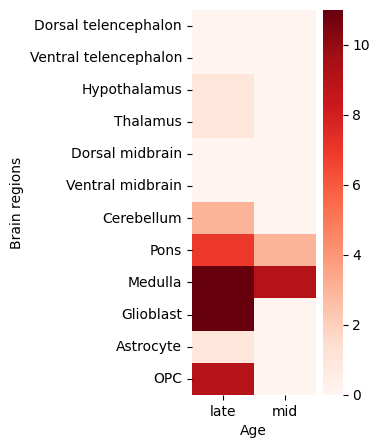

In [57]:
fig, ax = plt.subplots(figsize=(2, 5))
ax=sns.heatmap(df_freq, xticklabels=True, yticklabels=True, cmap='Reds')
ax.set(
    xlabel='Age', 
    ylabel='Brain regions',
)
plt.show()

In [79]:
regions_to_keep = [
    'Telencephalon', 'Midbrain', 'Hypothalamus', 'Thalamus', 'Cerebellum', 
    'Pons', 'Medulla', 'Glioblast', 'Astrocyte', 'OPC'
]
df_plot = df_res.loc[regions_to_keep]

In [58]:
df_plot = df_res.reset_index().melt(id_vars="Region")
df_plot["Age"] = df_plot["Age"].str.replace("_", " ").astype("category")

In [59]:
df_plot

,Region,Age,value
0,Dorsal telencephalon,mid,0.000000
1,Ventral telencephalon,mid,0.000000
2,Hypothalamus,mid,0.000000
3,Thalamus,mid,0.000000
4,Dorsal midbrain,mid,0.000000
5,Ventral midbrain,mid,0.000000
6,Cerebellum,mid,0.000000
7,Pons,mid,0.000000
8,Medulla,mid,1.366194
9,Glioblast,mid,0.000000


In [ ]:
class MidpointNormalize(mcolors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Ensure vmin and vmax are properly set
        if self.vmin is None or self.vmax is None:
            raise ValueError("vmin and vmax must be set to use MidpointNormalize.")
        if self.midpoint is None:
            raise ValueError("midpoint must be set to use MidpointNormalize.")

        value = np.array(value, dtype=float)

        # Scale normalization linearly but adjust midpoint
        x = [self.vmin, self.midpoint, self.vmax]
        y = [0, 0.5, 1]  # Map vmin to 0, midpoint to 0.5 (white), and vmax to 1
        return np.ma.masked_array(np.interp(value, x, y))

In [ ]:
import matplotlib as mpl

In [ ]:
vmin = df_res.min().min()
vmax = df_res.max().max()
vpadding = (vmax - vmin)
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

In [80]:
df_plot = df_res

# Combine and calculate mean
df_plot.loc['Telencephalon'] = df_plot.loc[['Dorsal Telencephalon', 'Ventral Telencephalon']].mean()
df_plot.loc['Midbrain'] = df_plot.loc[['Dorsal Midbrain', 'Ventral Midbrain']].mean()

# Filter rows for `df_plot` and drop combined regions used in the mean calculation
regions_to_keep = [
    'Telencephalon', 'Midbrain', 'Hypothalamus', 'Thalamus', 'Cerebellum', 
    'Pons', 'Medulla', 'Glioblast', 'Astrocyte', 'OPC'
]
df_plot = df_plot.loc[regions_to_keep]

print(df_plot)

Age                 mid      late
Region                           
Telencephalon -0.681670 -1.430641
Midbrain       0.000000  0.802279
Hypothalamus   0.000000  0.000000
Thalamus       0.000000  0.000000
Cerebellum     0.000000  0.000000
Pons           0.000000  0.335168
Medulla        1.366194  1.199167
Glioblast      0.000000  1.315239
Astrocyte      0.000000  0.000000
OPC            0.000000  0.887657


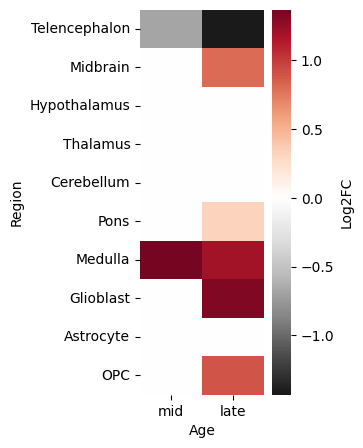

In [86]:
fig, ax = plt.subplots(figsize=(2, 5))
ax = sns.heatmap(
    df_plot,
    xticklabels=True,
    yticklabels=True,
    cmap="RdGy_r", 
    cbar_kws={"label": "Log2FC"},
    center=0
)
plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/04h_abundance_analysis/credible_effects_age_brackets_heatmap.pdf', bbox_inches='tight', dpi=300)
plt.show()

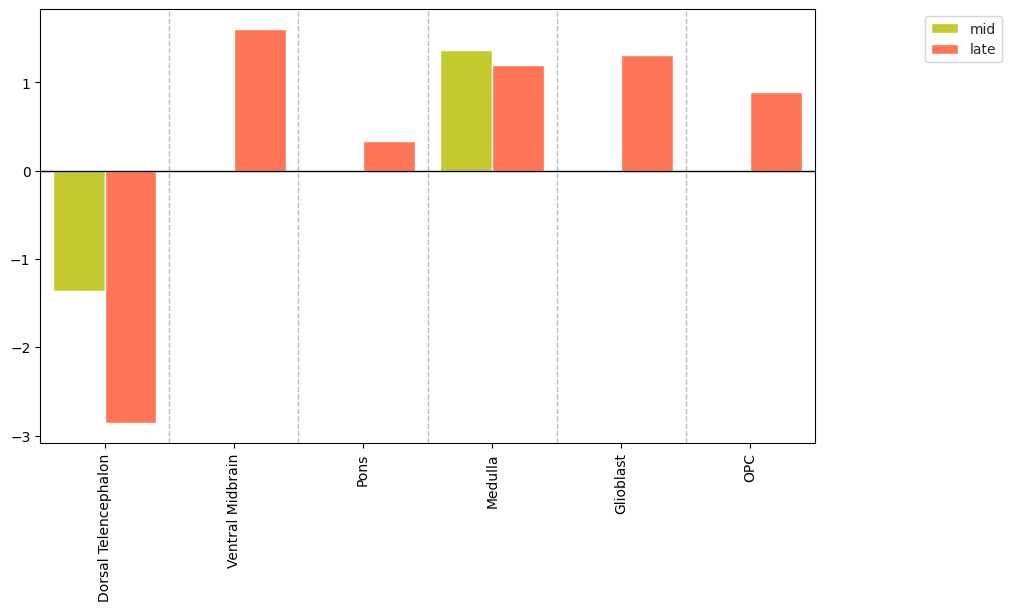

In [45]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.set_style("ticks")

sns.barplot(data=df_plot, 
            x="Region", 
            y='value', 
            hue="Age",
            hue_order=["mid", "late"],
            palette={"mid":'#c4c930',"late":'#ff7555'},
            saturation=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(loc='upper right', bbox_to_anchor=(1.25,1), ncol=1)
ax.set(xlabel=None, ylabel=None)
for i in range(1,len(df_plot["Region"].unique())):
    plt.axvline(x=i-0.5,linewidth=1, color='#bbbbbb', ls="--")
plt.axhline(y=0,linewidth=1, color='k')
plt.savefig('/hpc/pmc_rios/2.personal/rariese/scseq_analysis/BRO/time_course/figures/04h_abundance_analysis/credible_effects_age_brackets.pdf', bbox_inches='tight')
plt.show()

In [52]:
print(adata[(adata.obs['publication_covariate']=='Bessler et al., this study') & (adata.obs['binned_ages']== 'mid')].obs['hnoca_leiden_level_3'].value_counts())
print("")
print(adata[(adata.obs['publication_covariate']=='Bessler et al., this study') & (adata.obs['binned_ages']== 'mid')].obs['hnoca_level_3'].value_counts())


hnoca_leiden_level_3
Medulla NPC             3359
Medulla Neuron          2501
Pons NPC                1720
Dorsal Midbrain NPC      862
Cerebellar NPC           296
Hypothalamic NPC         256
Neuroepithelium          256
MC                       231
OPC                      151
Hypothalamic Neuron       80
Ventral Midbrain NPC      68
NPC                       67
Glioblast                 37
NC Derivatives             4
Name: count, dtype: int64

hnoca_level_3
Medulla NPC                    2589
Pons NPC                       2005
Medulla Neuron                 1529
Dorsal Midbrain NPC             961
Cerebellar NPC                  724
Hypothalamic NPC                407
Pons Neuron                     397
Glioblast                       262
Ventral Midbrain NPC            244
Cerebellar Neuron               214
Hypothalamic Neuron             176
Thalamic Neuron                 147
Thalamic NPC                    113
Dorsal Midbrain Neuron           63
OPC                         